In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
cohort = pd.read_csv('final_cohort_dod_cleaned.csv')

In [ ]:
print(cohort.columns)
cohort.head()
pd.value_counts(cohort['survival_status'])

Index(['age', 'bmi', 'SOFA', 'apsiii', 'charlson_comorbidity_index', 'los',
       'survival_status', 'wbc', 'blood_glucose', 'glucose_variability',
       'male'],
      dtype='object')


0    7553
1    4072
Name: survival_status, dtype: int64

In [ ]:
feature_cols = [
    "age",
    "male",
    "bmi",
    "SOFA",
    "apsiii",
    "charlson_comorbidity_index",
    "wbc",
    "blood_glucose",
    "glucose_variability",
]


X = cohort[feature_cols]

y = cohort["survival_status"]

In [ ]:
y = y.to_numpy(dtype=np.int8)
X = X.to_numpy(dtype=np.float32)
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(11625, 9)
(11625,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# scale the data

scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
# Define a neural network class
class MyNetwork(nn.Module):
    def __init__(self, input_dim):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)





In [ ]:
 # Defining alternate NN

 class AlternateNetwork(nn.Module):
    def __init__(self, input_dim):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.bn2(F.dropout(x, p=0.5))
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return torch.sigmoid(x)

In [ ]:
# Define a dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.y)

In [ ]:
# split into train and test sets
train_size = int(0.8 * len(y))
test_size = len(y) - train_size
train_dataset = MyDataset(X[:train_size], y[:train_size])
test_dataset = MyDataset(X[train_size:], y[train_size:])
print(len(train_dataset))
print(len(test_dataset))

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# create a model, loss function and optimizer
model = MyNetwork(X.shape[1])
criterion = torch.nn.BCELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



9300
2325


In [ ]:
# fuction to train the model
def train(model, train_loader, criterion, optimizer, weight=1):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        # apply weights to the loss function using a mask
        mask = labels == 1
        loss[mask] = loss[mask] * weight
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# function to test the model
def test(model, test_loader, criterion, weight=1):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            # apply weights to the loss function using a mask
            mask = labels == 1
            loss[mask] = loss[mask] * weight
            loss = loss.mean()
            running_loss += loss.item()
    return running_loss / len(test_loader)


weight = 1/(train_dataset.y.sum().item() / len(train_dataset.y))
#weight = 1
print(weight)
train_losses = []
test_losses = []
for epoch in range(50):
    train_loss = train(model, train_loader, criterion, optimizer, weight=weight)
    test_loss = test(model, test_loader, criterion, weight=weight)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(
        "Epoch: {}/{}.. ".format(epoch + 1, 20),
        "Training Loss: {:.3f}.. ".format(train_loss),
        "Test Loss: {:.3f}.. ".format(test_loss),
    )

1
Epoch: 1/20..  Training Loss: 0.665..  Test Loss: 0.643.. 
Epoch: 2/20..  Training Loss: 0.620..  Test Loss: 0.610.. 
Epoch: 3/20..  Training Loss: 0.592..  Test Loss: 0.589.. 
Epoch: 4/20..  Training Loss: 0.570..  Test Loss: 0.574.. 
Epoch: 5/20..  Training Loss: 0.557..  Test Loss: 0.560.. 
Epoch: 6/20..  Training Loss: 0.551..  Test Loss: 0.561.. 
Epoch: 7/20..  Training Loss: 0.549..  Test Loss: 0.556.. 
Epoch: 8/20..  Training Loss: 0.542..  Test Loss: 0.554.. 
Epoch: 9/20..  Training Loss: 0.541..  Test Loss: 0.552.. 
Epoch: 10/20..  Training Loss: 0.536..  Test Loss: 0.557.. 
Epoch: 11/20..  Training Loss: 0.537..  Test Loss: 0.549.. 
Epoch: 12/20..  Training Loss: 0.535..  Test Loss: 0.551.. 
Epoch: 13/20..  Training Loss: 0.533..  Test Loss: 0.548.. 
Epoch: 14/20..  Training Loss: 0.532..  Test Loss: 0.542.. 
Epoch: 15/20..  Training Loss: 0.534..  Test Loss: 0.543.. 
Epoch: 16/20..  Training Loss: 0.530..  Test Loss: 0.544.. 
Epoch: 17/20..  Training Loss: 0.534..  Test Lo

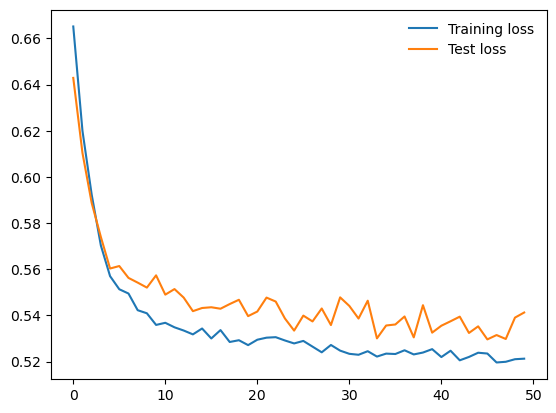

In [ ]:
# plot the training and test loss
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.legend(frameon=False)
plt.show()


In [ ]:
# make predictions on the test set
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        outputs = outputs.squeeze()
        y_pred.extend(outputs)
        y_true.extend(labels)

In [ ]:
# calculate the auc score
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

print("Accuracy score: {:.3f}".format(accuracy_score(y_true, np.array(y_pred) > 0.5)))
print("AUC score: {:.3f}".format(roc_auc_score(y_true, y_pred)))
print(classification_report(y_true, np.array(y_pred) > 0.5))

In [ ]:
# Try multiple weights

import copy

model = MyNetwork(X.shape[1])
criterion = torch.nn.BCELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)

optimal_weight = 1/(train_dataset.y.sum().item() / len(train_dataset.y)) - 1

weights = [1, optimal_weight*0.5, optimal_weight, 2*optimal_weight, 5*optimal_weight, 10*optimal_weight]
results = {}
for weight in weights:
    print("Weight: {}".format(weight))
    train_losses = []
    test_losses = []
    for epoch in range(20):
        train_loss = train(model, train_loader, criterion, optimizer, weight=weight)
        test_loss = test(model, test_loader, criterion, weight=weight)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    results[weight] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "model": copy.deepcopy(model)
    }



Weight: 1
Weight: 0.9268180423442776
Weight: 1.8536360846885551
Weight: 3.7072721693771102
Weight: 9.268180423442775
Weight: 18.53636084688555


In [ ]:
# print classification report for each weight
for weight in weights:
    print("Weight: {}".format(weight))
    model = results[weight]["model"]
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            outputs = outputs.squeeze()
            y_pred.extend(outputs)
            y_true.extend(labels)

    print("Accuracy score: {:.3f}".format(accuracy_score(y_true, np.array(y_pred) > 0.5)))
    print("AUC score: {:.3f}".format(roc_auc_score(y_true, y_pred)))
    print(classification_report(y_true, np.array(y_pred) > 0.5))
    print(confusion_matrix(y_true, np.array(y_pred) > 0.5))
    results[weight]["y_pred"] = y_pred
    results[weight]["y_true"] = y_true
    results[weight]["accuracy"] = accuracy_score(y_true, np.array(y_pred) > 0.5)
    results[weight]["auc"] = roc_auc_score(y_true, y_pred)
    results[weight]["confusion_matrix"] = confusion_matrix(y_true, np.array(y_pred) > 0.5)

In [ ]:
# plot confusion matrices for each weight
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(12, 6))
# create a subplot for each weight
for i, weight in enumerate(weights):
    plt.subplot(2, 3, i + 1)
    cm = results[weight]["confusion_matrix"]
    plt.imshow(cm, interpolation="nearest", cmap='rocket')
    plt.title(f"Weight: {weight:.2f} {'(Optimal)'*(i==2)}")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Recovered", "Died"], rotation=45)
    plt.yticks(tick_marks, ["Recovered", "Died"])

    # label the plot
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "white",
        )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
plt.savefig("confusion_matrix.png", dpi=300)